In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from config import census_key
import json
import requests 
#from census import Census


In [2]:
# Import Accident dataset

accident_data = pd.read_csv(r'usaccidents.csv')


# Drop unnecessary columns
reduced_accident_df = accident_data[["ID", "Severity", "Start_Time", "Start_Lat", "Start_Lng", "Street", "County", "State", "Zipcode", 
                                     "Weather_Timestamp", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", 
                                     "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition"]]
# create df
df = pd.DataFrame(reduced_accident_df)

# Convert dates(object) to integers
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

df['Start_Time'] = df['Start_Time'].apply(lambda x: x.date())

#add to df
df['Start_Time'] = pd.to_datetime(df['Start_Time'])


In [3]:
# Limit data to two-year period

start_date = "2017-01-01"
end_date = "2019-12-31"

mask = (df['Start_Time'] > start_date) & (df['Start_Time'] <= end_date)
two_year_df = df.loc[mask]
#two_year_df


In [4]:
# convert date field to integer and use for join field
new_dates = two_year_df['Start_Time'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

two_year_df['AccidentJoin'] = new_dates

# rename dataframe
accident_2_df = two_year_df
accident_2_df.head()

C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Street,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,AccidentJoin
9217,A-9218,2,2017-01-02,38.234737,-122.664314,Bodega Ave,Sonoma,CA,94952-1748,2017-01-02 14:15:00,46.4,45.2,76.0,30.02,10.0,NNW,3.5,NaN,Overcast,20170102
9218,A-9219,2,2017-01-02,38.246796,-122.627808,E Washington St,Sonoma,CA,94952,2017-01-02 14:15:00,46.4,45.2,76.0,30.02,10.0,NNW,3.5,NaN,Overcast,20170102
9219,A-9220,2,2017-01-02,38.192196,-122.543053,Old Lakeville No 2 Rd,Sonoma,CA,94954,2017-01-02 14:35:00,46.4,45.2,81.0,30.03,10.0,NW,3.5,NaN,Overcast,20170102
9220,A-9221,3,2017-01-02,37.732292,-122.414909,I-280 S,San Francisco,CA,94110,2017-01-02 12:56:00,52.0,NaN,61.0,30.02,10.0,SSW,15.0,NaN,Overcast,20170102
9221,A-9222,3,2017-01-02,38.211773,-122.144753,I-80 E,Solano,CA,94534,2017-01-02 14:54:00,52.0,NaN,66.0,29.98,10.0,SW,12.7,NaN,Mostly Cloudy,20170102


In [5]:
# convert state name in census data to 2 letter abbreviation
# dict taken from     https://gist.github.com/rogerallen/1583593

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
# create dataframe
state_info = pd.DataFrame.from_dict(us_state_abbrev, orient="index")

# reset index
state_info = state_info.reset_index()

# rename columns
state_info.columns = ['Name', 'Abbrev']

#state_info

In [6]:
# Census API

# State
url = "https://api.census.gov/data/2010/dec/sf1?get=P001001,NAME&for=state:*&key="

# Build query URL
query_url = url + census_key

census_response = requests.get(query_url)
census_json = census_response.json()
census_state_pd = pd.DataFrame(census_json)

# Drop column labels
census_state_df = census_state_pd.drop([census_state_pd.index[0]])

# drop unwanted column
census_state_df = census_state_df.drop(census_state_df.columns[[2]], axis=1)

# rename columns
census_state_df.columns = ['Pop', 'State']

# rearrange columns
census_state_df = census_state_df[['State', 'Pop']]

#convert population to int
census_state_df['Pop'] = census_state_df['Pop'].astype(int)

#census_state_df


In [7]:
# get accident count by Date
state_acc = accident_2_df.groupby(["State"]).count()["ID"]

#create df
state_acc_df = pd.DataFrame({"Accidents": state_acc})

#reset index
state_acc_df = state_acc_df.reset_index(drop=False)

#state_acc_df

In [8]:
#merge state census date with state name

# merge state abbrev to state population df
state_pop = census_state_df.merge(state_info,how='left', left_on='State', right_on='Name')

#state_pop
# merge population and accident dataframes
state_pop_acc = state_pop.merge(state_acc_df,how='left', left_on='Abbrev', right_on='State')

state_pop_sum = state_pop_acc
#state_pop_sum


In [9]:
#  Merge Accident and state population dataframes
state_pop_acc_df = state_pop.merge(state_acc_df,how='left', left_on='Abbrev', right_on='State')

capita_state_df = state_pop_acc_df

# drop columns
clean_state_df = state_pop_acc_df[["State_x", "Pop", "Accidents"]]

# drop Nan values
clean_state_df.dropna(inplace = True)

# Rename column
clean_state_df = clean_state_df.rename(columns={"State_x":"State"})

clean_state_df.head()
#clean_state_df


C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,State,Pop,Accidents
0,Alabama,4779736,36234.0
2,Arizona,6392017,59560.0
3,Arkansas,2915918,1723.0
4,California,37253956,522713.0
5,Louisiana,4533372,51632.0


In [10]:
# 15 most populated states
#Sort df
clean_state_df = clean_state_df.sort_values("Pop", ascending=False)

state_most = clean_state_df.head(15)
state_most


,State,Pop,Accidents
4,California,37253956,522713.0
43,Texas,25145561,248293.0
32,New York,19378102,117770.0
11,Florida,18801310,186712.0
15,Illinois,12830632,69311.0
38,Pennsylvania,12702379,69184.0
35,Ohio,11536504,44532.0
22,Michigan,9883640,72058.0
12,Georgia,9687653,70376.0
33,North Carolina,9535483,136313.0


In [11]:
state_most.set_index("State", inplace=True)

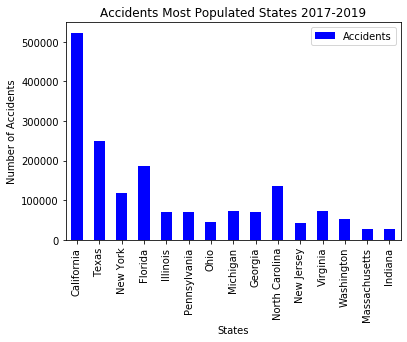

In [12]:
# Create bar graph most populated states
state_most.plot(kind="bar", facecolor="Blue", y="Accidents")

# Give the chart a title, x label, and y label
plt.title("Accidents Most Populated States 2017-2019")
plt.xlabel("States")
plt.ylabel("Number of Accidents")
plt.show

plt.savefig("../ProjectOneTeam5/output/6MostPopulatedStatesGraph.png", bbox_inches = "tight")


In [13]:
# 15 most populated states
#Sort df
clean_state_df = clean_state_df.sort_values("Pop", ascending=True)

state_least = clean_state_df.head(15)
state_least


,State,Pop,Accidents
50,Wyoming,563626,423.0
10,District of Columbia,601723,3199.0
45,Vermont,625741,568.0
34,North Dakota,672591,40.0
41,South Dakota,814180,52.0
9,Delaware,897934,4155.0
26,Montana,989415,442.0
39,Rhode Island,1052567,9080.0
29,New Hampshire,1316470,6747.0
19,Maine,1328361,1930.0


In [14]:
# Set state as index
state_least.set_index("State", inplace=True)

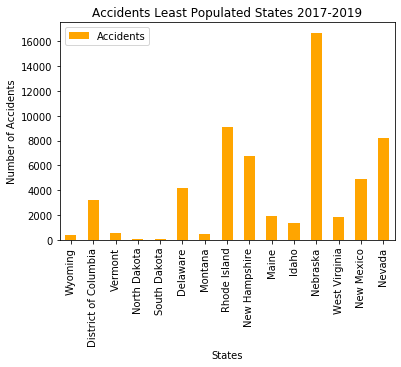

In [15]:
# Create bar graph least populated states


state_least.plot(kind="bar", facecolor="orange", y="Accidents")

# Give the chart a title, x label, and y label
plt.title("Accidents Least Populated States 2017-2019")
plt.xlabel("States")
plt.ylabel("Number of Accidents")
plt.show

plt.savefig("../ProjectOneTeam5/output/8LeastPopulatedStatesGraph.png", bbox_inches = "tight")


In [16]:
#Insight 5

# drop Nan values
capita_state_df.dropna(inplace = True)

#convert float to int
#capita_state_df["Accidents"] = capita_state_df["Accidents"].astype(int)


# Calculate accidents per capita
acc_capita = capita_state_df["Accidents"] / capita_state_df["Pop"]

capita_state_df["Accidents Per 10,000"] = acc_capita * 10000

capita_state_df = capita_state_df.sort_values("Accidents Per 10,000", ascending=False)

capita_state_df.head(20)


,State_x,Pop,Name,Abbrev,State_y,Accidents,"Accidents Per 10,000"
40,South Carolina,4625364,South Carolina,SC,SC,143674.0,310.622040
37,Oregon,3831074,Oregon,OR,OR,69814.0,182.230884
44,Utah,2763885,Utah,UT,UT,40417.0,146.232568
33,North Carolina,9535483,North Carolina,NC,NC,136313.0,142.953430
4,California,37253956,California,CA,CA,522713.0,140.310736
36,Oklahoma,3751351,Oklahoma,OK,OK,50727.0,135.223284
5,Louisiana,4533372,Louisiana,LA,LA,51632.0,113.893146
23,Minnesota,5303925,Minnesota,MN,MN,60160.0,113.425435
11,Florida,18801310,Florida,FL,FL,186712.0,99.307974
43,Texas,25145561,Texas,TX,TX,248293.0,98.742279
